In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, lognorm
from pysabr import Hagan2002LognormalSABR, Hagan2002NormalSABR
import scipy.stats as ss
from scipy.optimize import minimize
from sources.plotter import Plotter

from sources.bivariateMonteCarlo import BivariateMonteCarlo
from sources.bacheliermodel import BachelierModel
from sources.blackscholesmodel import BlackScholes
from sources.distribution_test import DistributionTest

## Question 2B:

In [2]:
bs = BlackScholes()
bachelier = BachelierModel()
plotter = Plotter()
BMC = BivariateMonteCarlo()
tests = DistributionTest()

# Standard settings:
n_steps = 251
S1_0 = 100 * 11
S2_0 = 100 * 4
n_sim = 100000 #number of simulations
volatility = np.array([0.37, 0.54]) 
daily_volatility = np.sqrt(volatility / n_steps)  # Scale to daily volatility

rho = 0.3
S0 = (S1_0, S2_0)
spread_0 = S1_0 - S2_0
K = spread_0
r = 0.05
T = 1

The call option price: 231.8851553674343
Standard deviation: 1.652603616462391


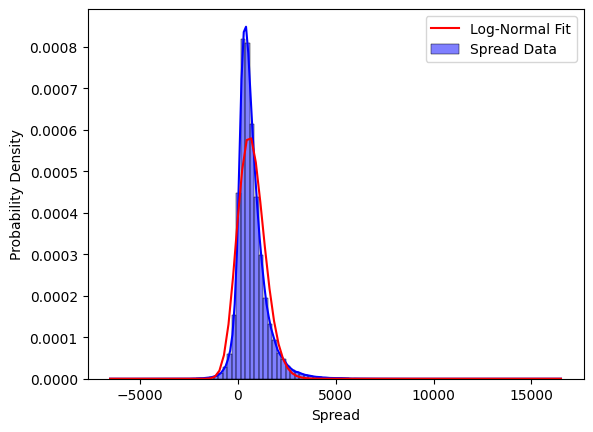

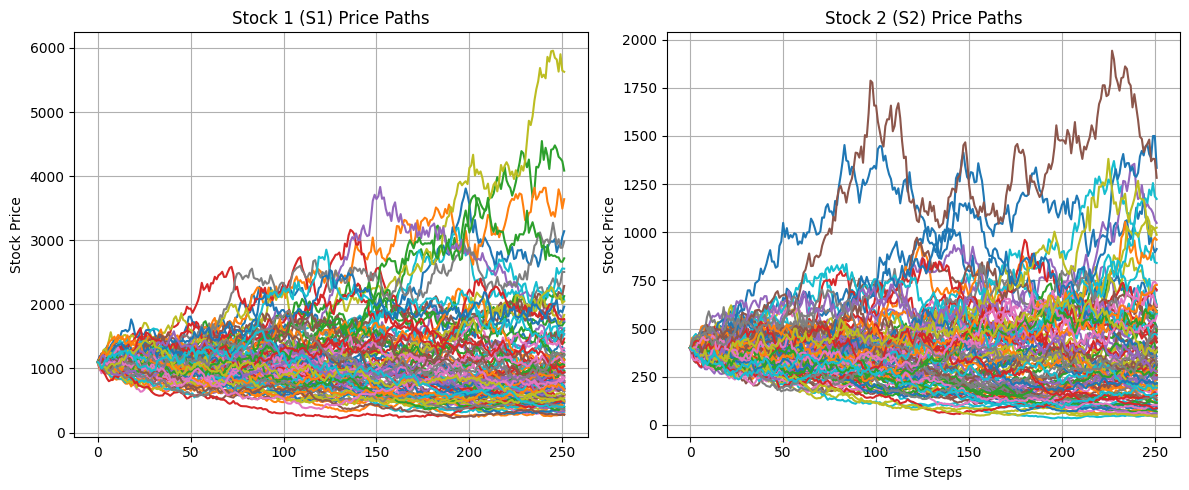

Anderson-Darling Test Statistic: nan
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Spread data does not follow a log-normal distribution (reject null hypothesis)


d:\studie\main_studie\files\stochastics_finance\E_FIN_SPFDM-1\assignment 2\sources\distribution_test.py:22: RuntimeWarning: invalid value encountered in log
  result = stats.anderson(np.log(spread_data))


In [3]:
stock_simulations = BMC.simulate_bivariate_monte_carlo(S0, daily_volatility, rho=rho, n_steps=n_steps, n_sim=n_sim)
option_price, payoffs, spread = BMC.monte_carlo_option_price(stock_simulations[0], stock_simulations[1], T, r, K)
n = np.size(payoffs)
std_error = np.std(payoffs, ddof=1) / np.sqrt(n)

print(f'The call option price: {option_price}')
print(f'Standard deviation: {std_error}')

plotter.plot_lognormaldistribution(spread)  
plotter.plot_stocks(stock_simulations, n_sim=100)
tests.run_Anderson_Darling_test(spread)

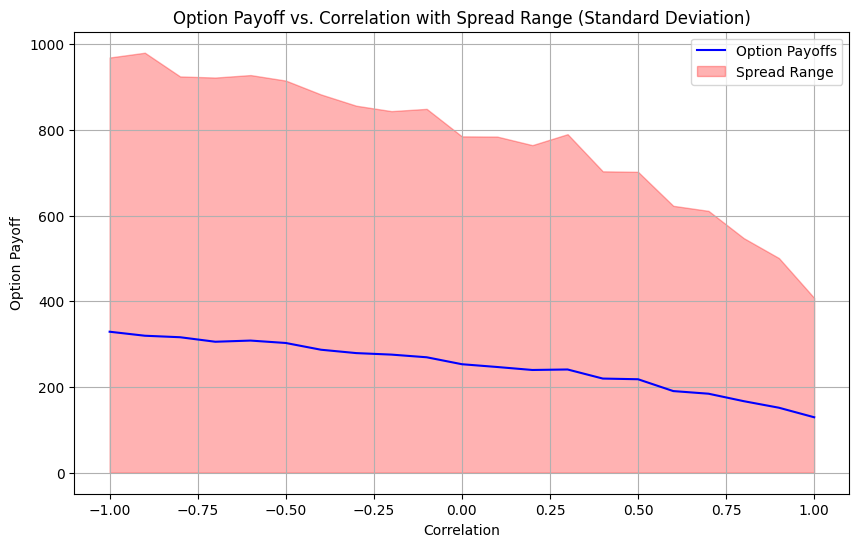

In [4]:
corr_range = np.linspace(-1, 1, 21)
option_price_list = []
spread_list = []

for cor in corr_range: 
    stock_simulations = BMC.simulate_bivariate_monte_carlo(S0, daily_volatility, rho=cor, n_steps=n_steps, n_sim=10000)
    option_price, payoffs, spread = BMC.monte_carlo_option_price(stock_simulations[0], stock_simulations[1], T, r, K)
    option_price_list.append(option_price)
    spread_list.append(np.std(payoffs))

plotter.plot_diffcorrelation_payoffs(option_price_list, corr_range, spread_list)

# Question 1C: 

In [5]:
# Portfolio variance of the spread: 

portfolio_variance_annual = BMC.calculate_spread_volatility(volatility[0], volatility[1], rho=0.3)
portfolio_variance_daily = BMC.calculate_spread_volatility(daily_volatility[0], daily_volatility[1], rho=0.3)

print(f"For daily spread volatility, we have {np.round(portfolio_variance_daily*100,2)}% and annual volatility  we have {np.round(portfolio_variance_annual*100,2)}%")

For daily spread volatility, we have 5.06% and annual volatility  we have 55.55%


In [6]:
# Calculate Bachelier volatility on daily and yearly basis
bachelier_volatility_daily = bachelier.daily_volatility_bachelier(S0, daily_volatility, rho)
bachelier_volatility_yearly = bachelier_volatility_daily * np.sqrt(252)

# Calculate Bachelier option price
bachelier_call_price = bachelier.calculate_bachelier_option_price(spread_0, K, bachelier_volatility_yearly, T, r)

# Calculate GBM volatility on a yearly basis
gbm_volatility_yearly = bachelier_volatility_yearly / spread_0

# Calculate GBM option price using Black-Scholes formula
gbm_price = bs.calc_blackscholes(spread_0, K, gbm_volatility_yearly, T, r)

# Simulate bivariate Monte Carlo for stock prices
stock_simulations = BMC.simulate_bivariate_monte_carlo(S0, daily_volatility, rho=rho, n_steps=n_steps, n_sim=n_sim)

# Calculate option price using Monte Carlo simulation
option_price, payoffs, spread = BMC.monte_carlo_option_price(stock_simulations[0], stock_simulations[1], T, r, K)

# Print all results
print("Bachelier Volatility (Daily):", bachelier_volatility_daily)
print("Bachelier Volatility (Yearly):", bachelier_volatility_yearly)
print("Bachelier Call Price:", bachelier_call_price)
print("GBM Volatility (Yearly):", gbm_volatility_yearly)
print("GBM Option Price:", gbm_price)
print("Monte Carlo Option Price:", option_price)

# Optionally, you can print payoffs as well if needed

Bachelier Volatility (Daily): 40.71544719673941
Bachelier Volatility (Yearly): 646.3376868081265
Bachelier Call Price: 245.27586801681778
GBM Volatility (Yearly): 0.9233395525830378
GBM Option Price: 260.3069999866847
Monte Carlo Option Price: 234.56758843249284


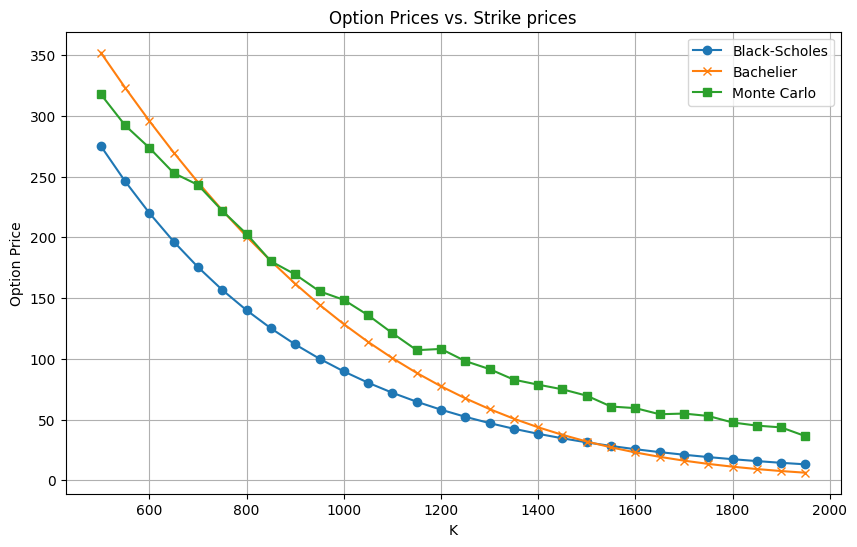

In [7]:
strikeprices = np.arange(500,2000,50)

bs_prices = []
bachelier_prices = []
monte_carlo_prices = []

for strikeprice in strikeprices:
    K = strikeprice
    bachelier_volatility_daily = bachelier.daily_volatility_bachelier(S0, daily_volatility, rho)
    bachelier_volatility_yearly = bachelier_volatility_daily * np.sqrt(252)
    bachelier_call_price = bachelier.calculate_bachelier_option_price(spread_0, K, bachelier_volatility_yearly, T, r )
    
    gbm_volatility_yearly = bachelier_volatility_yearly / S0
    gbm_price = bs.calc_blackscholes(spread_0,K , gbm_volatility_yearly,T,r)

    stock_simulations = BMC.simulate_bivariate_monte_carlo(S0, daily_volatility, rho=rho, n_steps=n_steps, n_sim=10000)
    option_price, payoffs, spread = BMC.monte_carlo_option_price(stock_simulations[0], stock_simulations[1], T, r, K)
    bs_prices.append(gbm_price[0])  # Assuming 'gbm_price' is Black-Scholes price
    bachelier_prices.append(bachelier_call_price)
    monte_carlo_prices.append(option_price)

# Create the plot
plotter.plot_strikeprices(strikeprices, bs_prices, bachelier_prices, monte_carlo_prices)

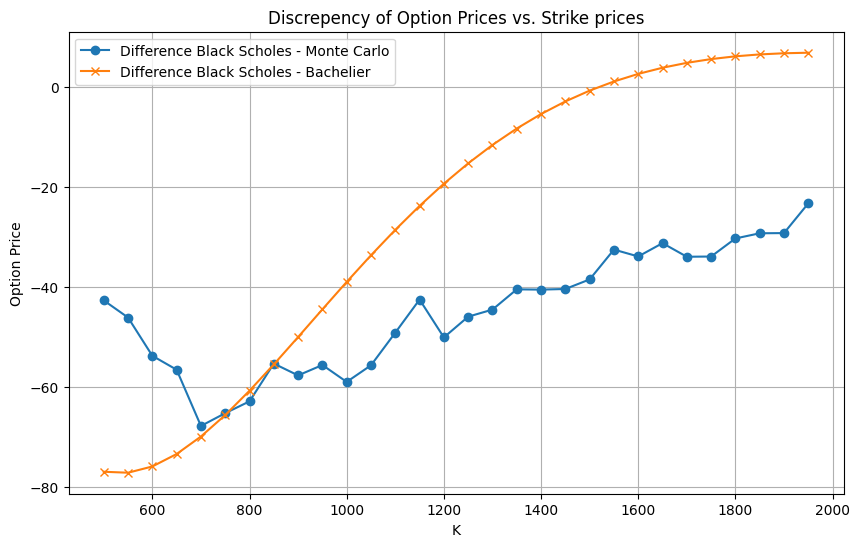

In [8]:
bs_bach_list = []
bs_mc_list = []
for i in range(len(bachelier_prices)):
    dif_bs_bach = bs_prices[i] - bachelier_prices[i]
    dif_bs_mc = bs_prices[i] - monte_carlo_prices[i]
    bs_mc_list.append(dif_bs_mc)
    bs_bach_list.append(dif_bs_bach)

plt.figure(figsize=(10, 6))
plt.plot(strikeprices, bs_mc_list, label='Difference Black Scholes - Monte Carlo', marker='o')
plt.plot(strikeprices, bs_bach_list, label='Difference Black Scholes - Bachelier', marker='x')
# plt.plot(strikeprices, monte_carlo_prices, label='Monte Carlo', marker='s')

plt.xlabel('K')
plt.ylabel('Option Price')
plt.title('Discrepency of Option Prices vs. Strike prices')
plt.legend()
plt.grid()

plt.show()

## Question 2b: 

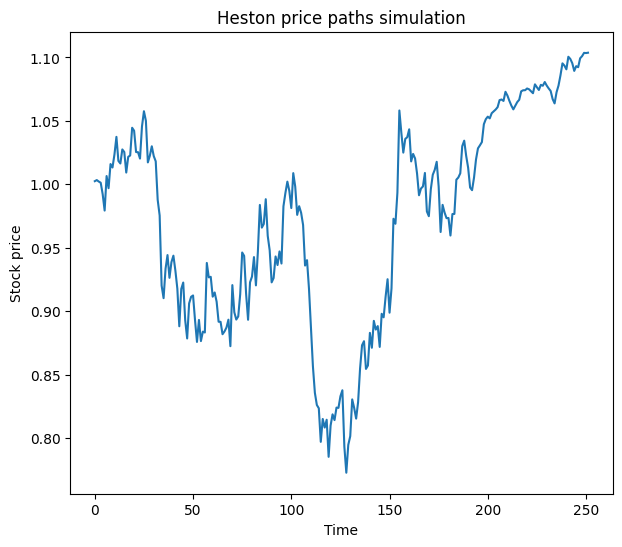

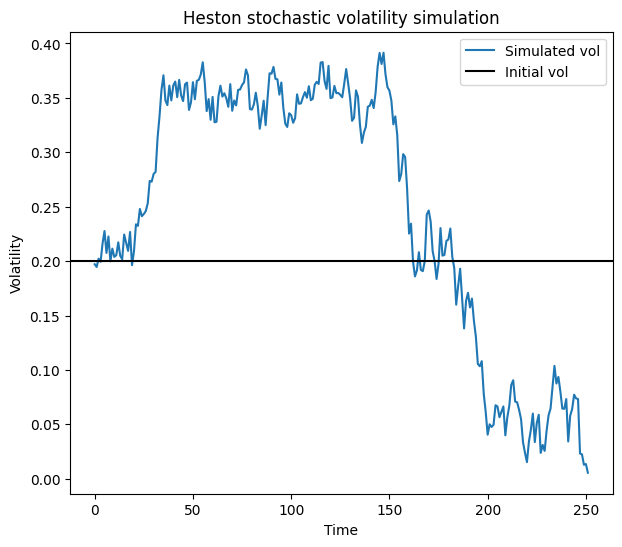

In [9]:
def generate_heston_paths(S, T, r, kappa, theta, v_0, rho, xi, 
                          steps, Npaths, return_vol=True):
    dt = T/steps
    size = (Npaths, steps)
    prices = np.zeros(size)
    sigs = np.zeros(size)
    S_t = S
    v_t = v_0
    for t in range(steps):
        WT = np.random.multivariate_normal(np.array([0,0]), 
                                           cov = np.array([[1,rho],
                                                          [rho,1]]), 
                                           size=paths) * np.sqrt(dt) 
        
        S_t = S_t*(np.exp( (r- 0.5*v_t)*dt+ np.sqrt(v_t) *WT[:,0] ) ) 
        v_t = np.abs(v_t + kappa*(theta-v_t)*dt + xi*np.sqrt(v_t)*WT[:,1])
        prices[:, t] = S_t
        sigs[:, t] = v_t
    
    
    log_ret = np.log(prices[1:]/prices[:-1])
    
    return (prices, sigs, log_ret)

kappa =1
theta = 0.04
v_0 =  0.04
xi = 0.5
r = 0
S = 1
paths =1
steps = 252
T = 1
rho = -0.7
prices, sigs, log_ret = generate_heston_paths(S, T, r, kappa, theta,
                                    v_0, rho, xi, steps, paths,
                                    return_vol=True)    
    
"""   
all_log_rets = log_ret.flatten()    
plt.figure(figsize=(7, 6))
plt.hist(all_log_rets, bins=100, density=True, alpha=0.6, color='g', label='Histogram')

mu_heston, std_heston = norm.fit(all_log_rets)
xmin_heston, xmax_heston = plt.xlim()
x_heston = np.linspace(xmin_heston, xmax_heston, 100)
p_heston = norm.pdf(x_heston, mu_heston, std_heston)
plt.plot(x_heston, p_heston, 'k', linewidth=2, label='Normal Distribution')
plt.title('Simulated log-returns from Heston model')
plt.xlabel('Log-returns')
plt.ylabel('Density')
plt.legend()
plt.show()    


skewness_heston = ss.skew(all_log_rets)
print("The skewness of log returns for Heston model =", skewness_heston)
kurtosis_heston = ss.kurtosis(all_log_rets)
print("The kurtosis of log returns for Heston model =", kurtosis_heston)
"""

plt.figure(figsize=(7,6))
plt.plot(prices.T)
plt.title('Heston price paths simulation')
plt.xlabel('Time')
plt.ylabel('Stock price')
plt.show()

plt.figure(figsize=(7,6))
plt.plot(np.sqrt(sigs).T, label='Simulated vol')
plt.axhline(np.sqrt(theta), color='black', label='Initial vol')
plt.title('Heston stochastic volatility simulation')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()



In [10]:
import numpy as np

def sim_sabr(F0, r, sigma_zero, beta, rho, eta, alpha, T, N, dt):
    """
    Simulate the SABR model paths for stock price and volatility.

    Parameters:
        F0 (float): Initial stock price.
        r (float): Risk-free interest rate.
        sigma_zero (float): Initial volatility.
        beta (float): SABR beta parameter.
        rho (float): SABR rho parameter.
        eta (float): SABR eta parameter.
        alpha (float): SABR alpha parameter.
        T (float): Time to maturity.
        N (int): Number of time steps.
        dt (float): Time step size.

    Returns:
        tuple: A tuple containing two NumPy arrays:
            - stock (np.ndarray): Array of simulated stock price values.
            - var (np.ndarray): Array of simulated volatility values.
    """
    # Initialize the mean and covariance matrix for Wiener process
    mu = np.array([0, 0])
    cov = np.array([[1, rho], [rho, 1]])

    # Generate correlated Wiener process samples
    W = np.random.multivariate_normal(mu, cov, size=N)

    # Extract the two Wiener processes
    W = np.array(W)
    W1 = W[:, 0]
    W2 = W[:, 1]

    # Initialize arrays for stock price and volatility
    stock = np.zeros(N + 1)
    var = np.zeros(N + 1)
    
    # Set initial values
    stock[0] = F0
    var[0] = sigma_zero

    # Simulate SABR model paths
    for i in range(1, N + 1):
        stock[i] = stock[i-1] + var[i-1] * stock[i-1]**beta * W1[i - 1] * np.sqrt(dt)
        var[i] = var[i-1] * np.exp(-0.5 * (alpha**2) * dt + alpha * W2[i - 1] * np.sqrt(dt))
    
    return stock, var

In [19]:
def calc_option_price(forward_price_last_element, K, F0, moneyness, option_type):
    if option_type == 'call':
        atm_strike = F0
        itm_10_strike = F0 * 0.90
        otm_10_strike = F0 * 1.10
        itm_25_strike = F0 * 0.75
        otm_25_strike = F0 * 1.25
        
        atm_price = []
        itm_10 = []
        otm_10 = []
        itm_25 = []
        otm_25 = []
        
        for i in forward_price_last_element:
            atm_price.append(np.maximum(i - atm_strike, 0))
            itm_10.append(np.maximum(i - itm_10_strike, 0))
            otm_10.append(np.maximum(i - otm_10_strike, 0))
            itm_25.append(np.maximum(i - itm_25_strike, 0))
            otm_25.append(np.maximum(i - otm_25_strike, 0))
            
        average_price_atm = np.mean(atm_price)
        average_price_itm10 = np.mean(itm_10)
        average_price_otm10 = np.mean(otm_10)
        average_price_itm25 = np.mean(itm_25)
        average_price_otm25 = np.mean(otm_25)
        
        option_price = [average_price_itm25, average_price_itm10, average_price_atm, average_price_otm10, average_price_otm25]
        
    if option_type == 'put':
        atm_strike = F0
        itm_10_strike = F0 * 1.10
        otm_10_strike = F0 * 0.90
        itm_25_strike = F0 * 1.25
        otm_25_strike = F0 * 0.75
        
        atm_price = []
        itm_10 = []
        otm_10 = []
        itm_25 = []
        otm_25 = []
        
        for i in forward_price_last_element:
            atm_price.append(np.maximum(atm_strike - i, 0))
            itm_10.append(np.maximum(itm_10_strike - i, 0))
            otm_10.append(np.maximum(otm_10_strike - i, 0))
            itm_25.append(np.maximum(itm_25_strike - i, 0))
            otm_25.append(np.maximum(otm_25_strike - i, 0))
        
        average_price_atm = np.mean(atm_price)
        average_price_itm10 = np.mean(itm_10)
        average_price_otm10 = np.mean(otm_10)
        average_price_itm25= np.mean(itm_25)
        average_price_otm25= np.mean(otm_25)
        
        option_price = [average_price_otm25, average_price_otm10, average_price_atm, average_price_itm10, average_price_itm25]
        
    
    return(option_price)

In [12]:
def sabr_package(strikes, F0, beta, sigma_zero, rho, alpha):
    """
    Calculate SABR implied volatility for a list of strikes.

    Parameters:
        strikes (list): List of strike prices.
        F0 (float): Initial forward price.
        beta (float): SABR beta parameter.
        sigma_zero (float): Initial volatility.
        rho (float): SABR rho parameter.
        alpha (float): SABR alpha (volvol) parameter.

    Returns:
        list: A list of SABR implied volatilities for the given strikes.
    """
    # Create a Hagan2002LognormalSABR model
    sabr_model = Hagan2002LognormalSABR(f=F0, beta=beta, v_atm_n=sigma_zero, rho=rho, volvol=alpha)

    # Calculate implied volatilities using the SABR model
    implied_volatilities = [sabr_model.lognormal_vol(k) for k in strikes]

    return implied_volatilities


In [13]:
def generate_heston_paths(S, T, r, kappa, theta, v_0, rho, xi, 
                          steps, Npaths, return_vol=True):
    """
    Generate paths for the Heston stochastic volatility model.

    Parameters:
        S (float): Initial stock price.
        T (float): Time to maturity.
        r (float): Risk-free interest rate.
        kappa (float): Mean-reversion speed for volatility.
        theta (float): Long-term mean for volatility.
        v_0 (float): Initial volatility.
        rho (float): Correlation between stock price and volatility.
        xi (float): Volatility of volatility.
        steps (int): Number of time steps.
        Npaths (int): Number of paths to generate.
        return_vol (bool): If True, return volatility paths; if False, return price paths.

    Returns:
        tuple: A tuple containing two NumPy arrays:
            - prices (np.ndarray): Array of simulated stock price paths.
            - volatilities (np.ndarray): Array of simulated volatility paths (if return_vol is True).
            - log_returns (np.ndarray): Array of log returns (if return_vol is False).
    """
    dt = T / steps
    size = (Npaths, steps)
    prices = np.zeros(size)
    volatilities = np.zeros(size)
    
    S_t = S
    v_t = v_0
    
    for t in range(steps):
        # Generate correlated Wiener processes
        WT = np.random.multivariate_normal(np.array([0, 0]), 
                                           cov=np.array([[1, rho], [rho, 1]]), 
                                           size=Npaths) * np.sqrt(dt)
        
        # Update stock prices and volatilities
        S_t = S_t * (np.exp((r - 0.5 * v_t) * dt + np.sqrt(v_t) * WT[:, 0]))
        v_t = np.abs(v_t + kappa * (theta - v_t) * dt + xi * np.sqrt(v_t) * WT[:, 1])
        
        prices[:, t] = S_t
        volatilities[:, t] = v_t
    
    log_returns = np.log(prices[:, 1:] / prices[:, :-1])
    
    if return_vol:
        return prices, volatilities
    else:
        return prices, log_returns

In [14]:
def calc_blackscholes(S0, K, sigma, T, r, option_type='call'):
    """
    Calculate the Black-Scholes option price.

    Parameters:
        S0 (float): Initial stock price.
        K (float): Strike price.
        sigma (float): Volatility of the underlying asset.
        T (float): Time to maturity (in years).
        r (float): Risk-free interest rate.
        option_type (str): Type of option, either 'call' (default) or 'put'.

    Returns:
        float: Black-Scholes option price.
    """
    # Calculate d1 and d2
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Calculate option price based on option type
    if option_type == 'call':
        C = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        return C
    elif option_type == 'put':
        P = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
        return P

call prices sabr:
 [0.26252919252260354, 0.14043580788356294, 0.07813697455060653, 0.03638435155855701, 0.007983173425409721]
put prices sabr:
 [0.012149837120965278, 0.040056452481924736, 0.07775761914896831, 0.13600499615691886, 0.2576038180237715]
sigma_bs 0.2
call prices Black Scholes:
 [0.25581185846275545, 0.13589108116054793, 0.07965567455405798, 0.04292010941409885, 0.014824118915130247]
put_prices Black Scholes:
 [0.005811858462755511, 0.03589108116054801, 0.07965567455405798, 0.14292010941409894, 0.26482411891513014]


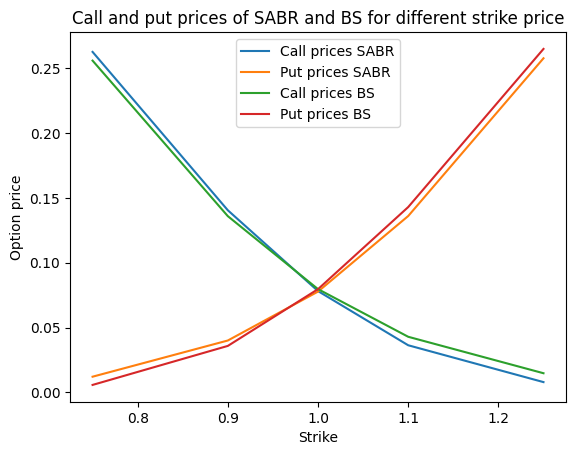

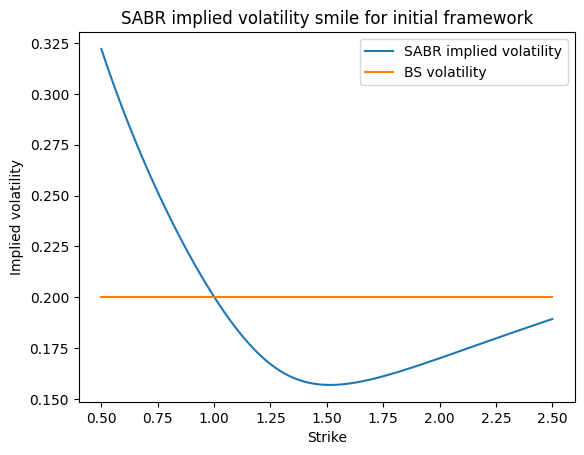

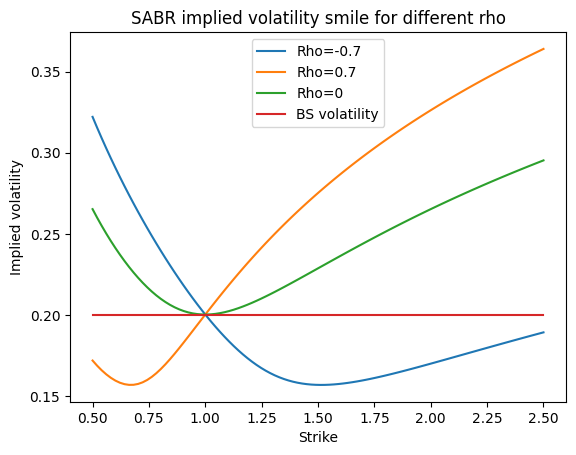

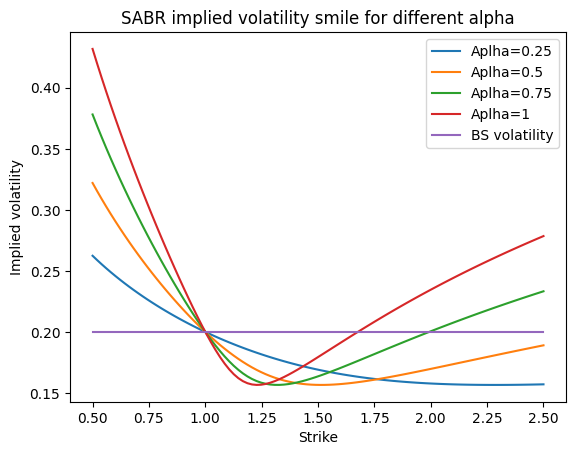

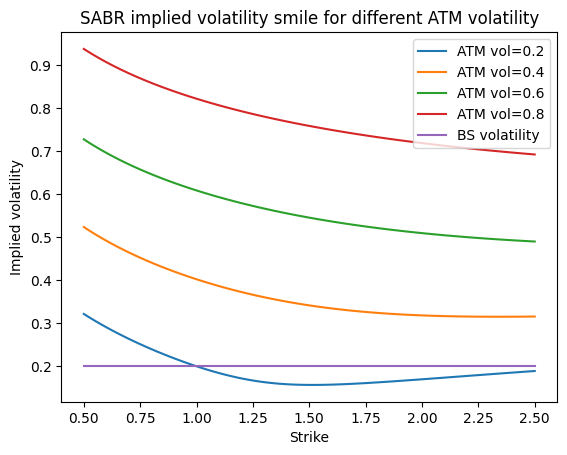

0.05269872574532049 -0.7896168202885603 7.350271120699081


In [20]:
F0 =1
r = 0
sigma_zero = 0.2
beta = 1
rho = -0.7
eta = 0.5
alpha = 0.5
T = 1
N = 252
dt = T / N
M = 10000
K=F0
moneyness = [0.9, 1.1, 0.75, 1.25]

forward_price_last_element = []
log_ret_path = []
stock_sigma = []
forward_prices = []



    
for i in range(M):
    forward_price, stock_vol = sim_sabr(F0, r, sigma_zero, beta, rho, eta, alpha, T, N, dt)
    forward_prices.append(forward_price)
    forward_price_last_element.append(forward_price[-1])
    stock_sigma.append(stock_vol)
    log_ret_path.append(np.log(forward_price[1:] / forward_price[:-1]) )
    
"""
plt.figure(figsize=(7,6))
plt.plot(forward_price)
plt.title('SABR price paths simulation')
plt.xlabel('Time')
plt.ylabel('Stock price')
plt.show()

plt.figure(figsize=(7,6))
plt.plot(stock_vol, label='Simulated vol')
plt.axhline(sigma_zero, color='black', label='Initial vol')
plt.title('SABR stochastic volatility simulation')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()    
    
log_ret_flat = np.array(log_ret_path).flatten()


plt.figure(figsize=(7, 6))
plt.hist(log_ret_flat, bins=100, density=True, alpha=0.6, color='g', label='Histogram')
mu1, std1 = norm.fit(log_ret_flat)
xmin1, xmax1 = plt.xlim()
x1 = np.linspace(xmin1, xmax1, 100)
p1 = norm.pdf(x1, mu1, std1)
plt.plot(x1, p1, 'k', linewidth=2, label='Normal Distribution')
plt.title('Simulated log-returns from SABR model')
plt.xlabel('Log-returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()

skewness_log_ret = ss.skew(log_ret_flat)
print("Skewness of SABR log returns =", skewness_log_ret)
kurtosis_log_ret = ss.kurtosis(log_ret_flat)
print("Kurtosis of SABR log returns =", kurtosis_log_ret)
"""
    

#### call prices for strike factor of [1, 0.9, 1.1, 0.75, 1.25]
call_prices_sabr = calc_option_price(forward_price_last_element, K, F0, moneyness, option_type='call') 

#### put prices for stike factor of [1, 1.1, 0.9, 1.25, 0.75]
put_prices_sabr = calc_option_price(forward_price_last_element, K, F0, moneyness, option_type='put')  

print("call prices sabr:\n",call_prices_sabr)
print("put prices sabr:\n",put_prices_sabr)

moneyness_call = [0.75, 0.9, 1, 1.1, 1.25]
moneyness_put = [0.75, 0.9, 1, 1.1, 1.25]
call_prices_bs = []
put_prices_bs = []

sigma_bs = 0.2

print("sigma_bs", sigma_bs)

for factor in moneyness_call:
    call_prices_bs.append(calc_blackscholes(F0, K*factor, sigma_bs, T, r, option_type = 'call'))
    
for factor in moneyness_put:
    put_prices_bs.append(calc_blackscholes(F0, K*factor, sigma_zero, T, r, option_type = 'put'))
print("call prices Black Scholes:\n", call_prices_bs)
print("put_prices Black Scholes:\n", put_prices_bs)

plt.plot(moneyness_call, call_prices_sabr, label ='Call prices SABR')
plt.plot(moneyness_call, put_prices_sabr, label ='Put prices SABR')
plt.plot(moneyness_call, call_prices_bs, label ='Call prices BS')
plt.plot(moneyness_call, put_prices_bs, label ='Put prices BS')
plt.legend()
plt.xlabel('Strike')
plt.ylabel('Option price')
plt.title('Call and put prices of SABR and BS for different strike price')
plt.show()

n_strikes = 100
strikes = np.linspace(0.5, 2.5, n_strikes)

volatility_smile_1 = sabr_package(strikes, F0, beta, sigma_zero, rho, alpha)

plt.plot(strikes, volatility_smile_1, label = 'SABR implied volatility')
plt.plot(strikes, np.full_like(strikes, sigma_bs), label = 'BS volatility')
plt.xlabel('Strike')
plt.ylabel('Implied volatility')
plt.title('SABR implied volatility smile for initial framework')
plt.legend()
plt.show()

volatility_smile_2 = sabr_package(strikes, F0, beta, sigma_zero, rho, alpha)
volatility_smile_3 = sabr_package(strikes, F0, beta, sigma_zero, -rho, alpha)
volatility_smile_4 = sabr_package(strikes, F0, beta, sigma_zero, 0, alpha)

plt.plot(strikes, volatility_smile_2, label = 'Rho=-0.7')
plt.plot(strikes, volatility_smile_3, label = 'Rho=0.7')
plt.plot(strikes, volatility_smile_4, label = 'Rho=0')
plt.plot(strikes, np.full_like(strikes, sigma_bs), label = 'BS volatility')
plt.xlabel('Strike')
plt.ylabel('Implied volatility')
plt.title('SABR implied volatility smile for different rho')
plt.legend()
plt.show()

volatility_smile_5 = sabr_package(strikes, F0, beta, sigma_zero, rho, alpha)
volatility_smile_6 = sabr_package(strikes, F0, beta, sigma_zero, rho, 0.25)
volatility_smile_7 = sabr_package(strikes, F0, beta, sigma_zero, rho, 0.75)
volatility_smile_8 = sabr_package(strikes, F0, beta, sigma_zero, rho, 1)

#### alpha =0 is bs voor in report
plt.plot(strikes, volatility_smile_6, label = 'Aplha=0.25')
plt.plot(strikes, volatility_smile_5, label = 'Aplha=0.5')
plt.plot(strikes, volatility_smile_7, label = 'Aplha=0.75')
plt.plot(strikes, volatility_smile_8, label = 'Aplha=1')

plt.plot(strikes, np.full_like(strikes, sigma_bs), label = 'BS volatility')
plt.xlabel('Strike')
plt.ylabel('Implied volatility')
plt.title('SABR implied volatility smile for different alpha')
plt.legend()
plt.show()

volatility_smile_9 = sabr_package(strikes, F0, beta, sigma_zero, rho, alpha)
volatility_smile_10 = sabr_package(strikes, F0, beta, 0.4, rho, alpha)
volatility_smile_11 = sabr_package(strikes, F0, beta, 0.6, rho, alpha)
volatility_smile_12 = sabr_package(strikes, F0, beta, 0.8, rho, alpha)

#### alpha =0 is bs voor in report
plt.plot(strikes, volatility_smile_9, label = 'ATM vol=0.2')
plt.plot(strikes, volatility_smile_10, label = 'ATM vol=0.4')
plt.plot(strikes, volatility_smile_11, label = 'ATM vol=0.6')
plt.plot(strikes, volatility_smile_12, label = 'ATM vol=0.8')

plt.plot(strikes, np.full_like(strikes, sigma_bs), label = 'BS volatility')
plt.xlabel('Strike')
plt.ylabel('Implied volatility')
plt.title('SABR implied volatility smile for different ATM volatility')
plt.legend()
plt.show()


strikes_SP500 = np.array([
    4520.00, 4525.00, 4530.00, 4535.00, 4540.00,
    4545.00, 4550.00, 4555.00, 4560.00, 4565.00,
    4570.00, 4575.00, 4580.00, 4585.00, 4590.00, 4595.00, 4600.00, 4605.00, 4610.00, 4615.00
])
iv_SP500 = np.array([
    17.06, 10.77, 13.56, 12.88, 8.30,
    6.87, 5.77, 4.17, 1.37, 0.00,
    1.52, 2.44, 3.30, 4.14, 4.95,
    5.75, 6.54, 7.31, 8.07, 0.00
])

sabr_model = Hagan2002LognormalSABR(f=4567.80)
alpha, rho, volvol = sabr_model.fit(k = strikes_SP500, v_sln = iv_SP500)
print(alpha, rho, volvol)